#### Import TensorFlow and other libraries


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# %pip install tensorflow --quiet
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, losses
# from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

from imported_files.paths_n_vars import intra_annotated_file, features_file

User defined functions

In [2]:
def plot_signal(x : list|range ,y : list , x_label = "" , y_label = "" , title = ""):
    plt.grid(True)
    plt.plot(x,y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()
    plt.close()

def MyMinMaxScaler(dataframe):
    '''
    Scales each PPG segment individually
    Function assumes the PPG segments are present column wise in the given DataFrame
    '''
    normalized_list = []

    for _ , column in dataframe.items():
        segment_min = tf.reduce_min(column)
        segment_max = tf.reduce_max(column) 
        norm_value = (tf.convert_to_tensor(column) - segment_min) / (segment_max - segment_min)
        normalized_list.append(norm_value)
    
    return np.array(normalized_list)

#### Load the dataset

labels = 0_1     0.0
0_2     0.0
0_3     0.0
0_4     0.0
0_5     0.0
       ... 
9_64    1.0
9_74    1.0
9_78    1.0
9_95    1.0
9_96    1.0
Name: 0, Length: 6669, dtype: float64
raw_data =            0_1       0_2       0_3       0_4       0_5       0_6       0_7  \
1    -0.041815  0.219870 -0.073337  0.174313  0.008353 -0.063914 -0.052148   
2    -0.043789  0.222160 -0.079727  0.188834  0.007409 -0.037660 -0.055700   
3    -0.045800  0.221264 -0.086917  0.200428  0.006388 -0.010793 -0.058342   
4    -0.047832  0.217293 -0.094864  0.208929  0.005141  0.016216 -0.060265   
5    -0.049867  0.210421 -0.103500  0.214245  0.003538  0.042878 -0.061669   
...        ...       ...       ...       ...       ...       ...       ...   
1246 -0.046270 -0.122461  0.032764 -0.138325  0.140099 -0.126210  0.197311   
1247 -0.053644 -0.112103  0.015662 -0.143542  0.123514 -0.134732  0.178520   
1248 -0.059602 -0.098977 -0.000377 -0.147536  0.105705 -0.143063  0.158841   
1249 -0.064253 -0.083123 -0.01

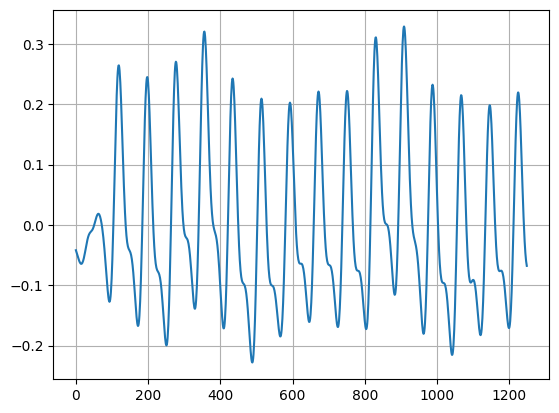

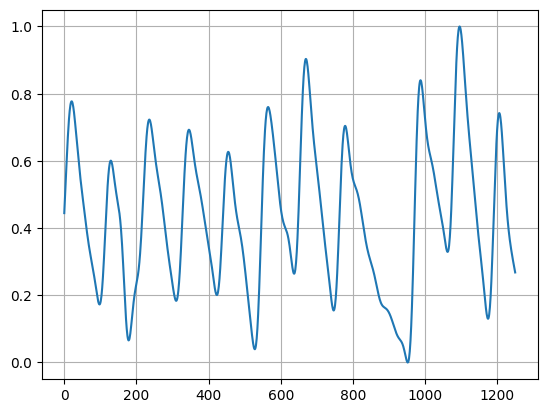

scaled_data = 
[[0.33407892 0.33053396 0.32692294 ... 0.30214272 0.29379214 0.28754702]
 [0.78713794 0.79127939 0.78966001 ... 0.21048138 0.23915499 0.2725664 ]
 [0.27347693 0.26241782 0.24997511 ... 0.39974853 0.37414097 0.35091166]
 ...
 [0.59742796 0.6188475  0.63909147 ... 0.51267065 0.5247084  0.53576908]
 [0.65208976 0.64576106 0.63786738 ... 0.56032156 0.53878947 0.51724711]
 [0.77350493 0.77041569 0.76551806 ... 0.65202177 0.64788497 0.63982856]]


In [3]:
rand_state = 54
test_fraction = 0.1

annotated_data = pd.read_csv(intra_annotated_file)
labels = annotated_data.iloc[0] # this will exract the annotation 2nd row
print(f"labels = {labels}")
raw_segments = (annotated_data.iloc[1 : , ])
print(f"raw_data = {raw_segments}")
assert not np.any(np.isnan(raw_segments))

import time
# scale data
start_scaling = time.perf_counter()
scaled_data = MyMinMaxScaler(raw_segments)
end_scaling = time.perf_counter()
print(f"Scaling took = {end_scaling - start_scaling}")
plot_signal(range(len(raw_segments["0_1"])) , raw_segments["0_1"])

# split the dataset using test_train_split() function
x_train, x_test, y_train, y_test = train_test_split(scaled_data , labels, test_size = test_fraction, random_state = rand_state, stratify = labels)

plot_signal(range(len(x_train[0])) , x_train[0])

print(f"scaled_data = \n{scaled_data}")

assert not np.any(np.isnan(scaled_data))

**First example: Basic autoencoder**

#### Simplified Autoencoder

In [7]:
class Autoencoder(Model):
    def __init__(self, latent_dim, num_samples, activation_function):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = tf.keras.Sequential([
                layers.Flatten(),
                layers.Dense(num_samples, activation = activation_function , name = "Encoder_in"),
                layers.Dense(latent_dim, activation = activation_function , name = "Latent_representation"),
                ])

        # Decoder
        self.decoder = tf.keras.Sequential([
                layers.Dense(latent_dim, activation = activation_function , name = "Decoder_in"),
                layers.Dense(num_samples, activation = activation_function , name = "Decoder_out"),
                ])
        
    def call(self, input_data):
        encoded = self.encoder(input_data)
        decoded = self.decoder(encoded)
        return decoded
assert not np.any(np.isnan(x_train))
num_samples = x_test.shape[1]
print(f"num_samples = {num_samples}")
latent_dim = 40
activation_func = 'sigmoid'
autoencoder = Autoencoder(latent_dim, num_samples, activation_func)

autoencoder.compile(optimizer = 'adam', loss = losses.MeanSquaredError())

tf.debugging.set_log_device_placement(True)

with tf.device('/device:GPU:0'):
  autoencoder.fit(x_train, x_train,
                epochs = 10,
                shuffle = True,
                batch_size = 32,
                validation_data = (x_test, x_test))

num_samples = 1250
Epoch 1/10
188/188 [==============================] - 10s 39ms/step - loss: 0.0554 - val_loss: 0.0518
Epoch 2/10
188/188 [==============================] - 8s 43ms/step - loss: 0.0510 - val_loss: 0.0503
Epoch 3/10
188/188 [==============================] - 8s 43ms/step - loss: 0.0497 - val_loss: 0.0484
Epoch 4/10
188/188 [==============================] - 8s 41ms/step - loss: 0.0469 - val_loss: 0.0466
Epoch 5/10
188/188 [==============================] - 8s 40ms/step - loss: 0.0455 - val_loss: 0.0450
Epoch 6/10
188/188 [==============================] - 8s 42ms/step - loss: 0.0440 - val_loss: 0.0440
Epoch 7/10
188/188 [==============================] - 7s 37ms/step - loss: 0.0427 - val_loss: 0.0422
Epoch 8/10
188/188 [==============================] - 8s 43ms/step - loss: 0.0410 - val_loss: 0.0408
Epoch 9/10
188/188 [==============================] - 8s 40ms/step - loss: 0.0397 - val_loss: 0.0395
Epoch 10/10
188/188 [==============================] - 8s 43ms/step - l

#### Testing the trained autoencoder

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1250)              0         
                                                                 
 Encoder_in (Dense)          (None, 1250)              1563750   
                                                                 
 Latent_representation (Den  (None, 40)                50040     
 se)                                                             
                                                                 
Total params: 1613790 (6.16 MB)
Trainable params: 1613790 (6.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


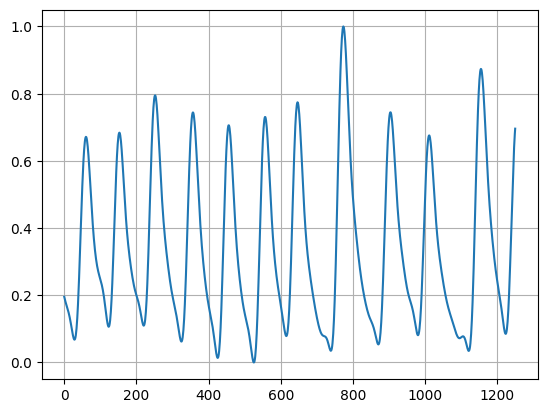

[0.19544252 0.19069603 0.18625032 ... 0.6618297  0.68046637 0.6958723 ]
range(0, 1250)
tf.Tensor([[0.38511747 0.3741138  0.3724841  ... 0.36566383 0.36681795 0.36908358]], shape=(1, 1250), dtype=float32)


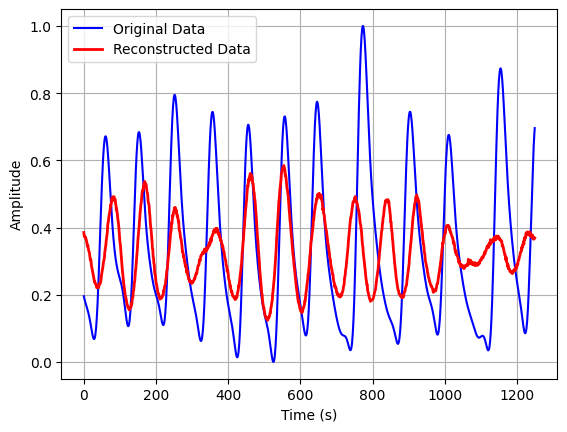

In [18]:
autoencoder.encoder.summary()
# plot_model(autoencoder, 'model.png', show_shapes=True)
segment = x_train[39]
# segment = segment  # Reshape the segment to match the autoencoder input shape
plot_signal(range(len(segment)),segment)
print(segment)
t = range(len(segment) )
print(t)
reconstructed_seg = autoencoder(tf.reshape(segment , [1,1250]))
print(reconstructed_seg)
plt.figure()
plt.plot(t, segment, 'b-', label='Original Data')
plt.plot(t, np.array(reconstructed_seg).reshape(1250,1), 'r-', linewidth = 2, label='Reconstructed Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

#### Feature Extracted and Save

In [24]:
def encode_data(array):
    temp = []
    header = []
    for i in range(array.shape[1]):
        encoded = autoencoder.encoder(tf.reshape(array[i] , [1,1250]))
        temp.append(encoded)
        # print(temp)
        header.append(f"Segment {i}")
    print(f"shape = {len(temp[0])}")
    return pd.DataFrame(data = temp )
print(type(scaled_data))
print(scaled_data.shape)
AE_features = encode_data(scaled_data)
# AE_features.to_csv("6.Features_extracted\\AE_features.csv")

<class 'numpy.ndarray'>
(6669, 1250)


KeyboardInterrupt: 